# EXPLORING GENDER PAY GAPS IN THE UNITED STATES

## INTRODUCTION

Although the gender pay gap between men and women has reduced considerably since the early 1980s, it remains an issue. In the past two decades, women earned an average of 80% of what men earned and this gap has stayed relatively consistent (Kochhar, 2023). As a result, we are interested in investigating the extent of salary difference between male and female workers, especially in higher paying jobs. 

We define ‘higher paying jobs’ as those that pay more than $\$50,000$ annually since the dataset catagorised salary into two groups: those who earn $\$50,000$ or less and those who earn more than $\$50,000$ instead of specific numbers. Therefore, the question to be answered is, "Are women underrepresented in higher-paying occupations relative to their share of the workforce?".

To help answer the question, the “Census Income” data from the UCI Machine Learning Repository was chosen, which contains various education levels, job position and salary statistics from the 1994 Census database (Kohavi & Becker, 1994). 

## METHODOLOGY

We begin by setting up the following hypotheses:
- Null Hypothesis $H_0$: women are underrepresented in higher paying occupations.
- Alternative Hypothesis $H_A$: women are not underrepresented in higher paying occupations.

Again, since salary was categorised into two groups instead of specific numbers, it is most appropriate to compute the proportion of men and women with each respective income category. We define the proportion of men that earn more than $\$50,000$ annually as $p_1$ and the proportion of women that earn more than $\$50,000$ annually as $p_2$.

## PRELIMINARY EXPLORATORY DATA ANALYSIS

In [1]:
#Loading in the necessary packages

library(cowplot)
library(datateachr)
library(broom)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(gridExtra)
library(tibble)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
#Reading in the data, using the column names given for the dataset (Kohavi & Becker, 1994)

colnames<- c("age", "work_class", "fnlwgt", "education_level", "year_of_education","marital_status", 
             "occupation", "relationship_status", "race","gender","capital_gain", "capital_loss", 
             "working_hours(/wk)", "native_country", "income")

income_data_main <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                        col_names = colnames)

head(income_data_main)

Rows: 32561 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): work_class, education_level, marital_status, occupation, relationsh...
dbl (6): age, fnlwgt, year_of_education, capital_gain, capital_loss, working...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,work_class,fnlwgt,education_level,year_of_education,marital_status,occupation,relationship_status,race,gender,capital_gain,capital_loss,working_hours(/wk),native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


**TABLE 1 - Raw dataset**

We are interested in investigating the United States (US) gender pay gaps because the countries included in the dataset were at different stages of economic development at the time when this survey was conducted, therefore other external factors besides gender could also have affected earning differences (United Nations, 2017). As a result, we want to minimise error and hold these factors constant by exploring the gender pay gap only in the US. Moreover, because the type of job (e.g private versus public sector jobs) does contribute to differences in salary, we want to isolate this factor and further compare the wage differences between women and men according to the type of jobs they are currently working at (Bank of Canada, 2019).

In [3]:
income_data <- income_data_main |>
            filter(native_country == "United-States" , work_class != '?') |>           #Filtering the variable 'native_country' to contain just the US
            select(work_class,education_level, occupation, gender, income) |> #Selecting the relevant variables.
            filter_all(all_vars(!is.na(.))) |>                     #Filtering rows with missing values for future calculations                     
            mutate(education_level = fct_recode(education_level,
                                               "Elementary-School" = "1st-4th",
                                               "Middle-School" = "5th-6th",         
                                               "High-School" = "7th-8th",
                                               "High-School" = "9th",
                                               "High-School" = "10th",
                                               "High-School" = "11th",
                                               "High-School" = "12th")) |> 
           mutate(work_class = fct_recode(work_class,
                                          'Self-employed' = 'Self-emp-not-inc',
                                          'Self-employed' = 'Self-emp-inc', 
                                          'Gov' = 'Federal-gov',
                                          'Gov' = 'Local-gov', 
                                          'Gov' = 'State-gov',
                                          'No-income' = 'Without-pay',
                                          'No-income' = 'Never-worked'))
            
head(income_data)

work_class,education_level,occupation,gender,income
<fct>,<fct>,<chr>,<chr>,<chr>
Gov,Bachelors,Adm-clerical,Male,<=50K
Self-employed,Bachelors,Exec-managerial,Male,<=50K
Private,HS-grad,Handlers-cleaners,Male,<=50K
Private,High-School,Handlers-cleaners,Male,<=50K
Private,Masters,Exec-managerial,Female,<=50K
Self-employed,HS-grad,Exec-managerial,Male,>50K


**TABLE 2 - Dataset with the selected and filtered variables and descriptions of variables.**

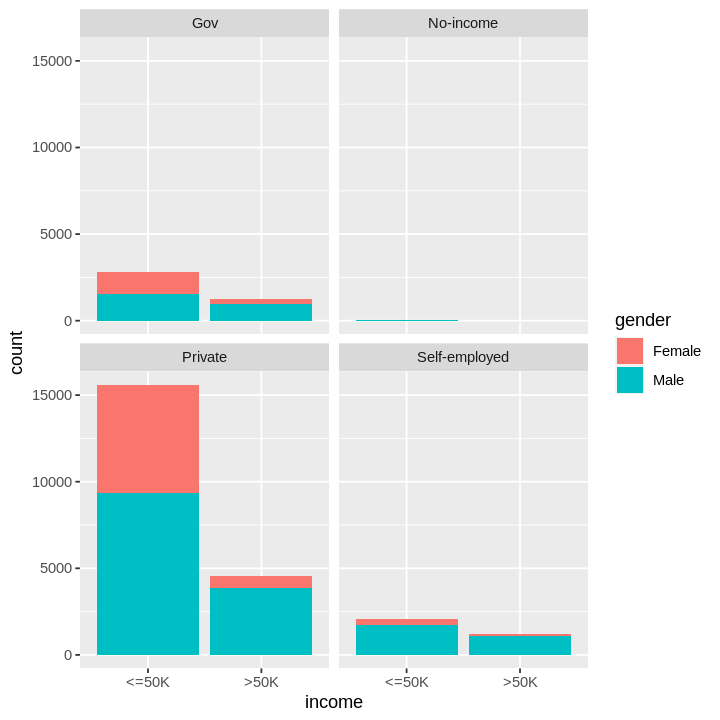

In [4]:
options(repr.plot.width = 6, repr.plot.height = 6)
income_data_plot <- income_data |>
                    ggplot() +
                    geom_bar(aes(x= income, fill = gender))  +
                    facet_wrap(~work_class)
income_data_plot

**FIGURE 1 - Bar charts comparing the differences in salary of male and female across different employment categories**

| Graph Title | Description |
| --- | --- |
| Gov | Jobs in the public sector (government jobs)|
| No-income | Those are currently unemployed and generate no-income |
| Private | Jobs in the private sector |
| Self-employed | Jobs that workers work independently |

**TABLE 3 - Table explaining the meaning of each category listed in Figure 1.**

From Figure 1, there seems to be a pattern that women earn less than their male counterparts, regardless of the job type. This can be shown by the dominance of turquoise (male representing)  columns over that of the pink (female representing). However, this is not adequate to conclude our hypothesis, thus we will further confirm this with a hypothesis test using the Central Limit Theorem (CLT). 

### CLT

It is important to note that the CLT relies on certain assumptions, such as the independence and identically distributed nature of the random variables being sampled, and the sample size being sufficiently large. We can check whether our dataset meets these assumptions by plotting the sampling distributions of male and female workers whose salary is $\$50,000$ or more.

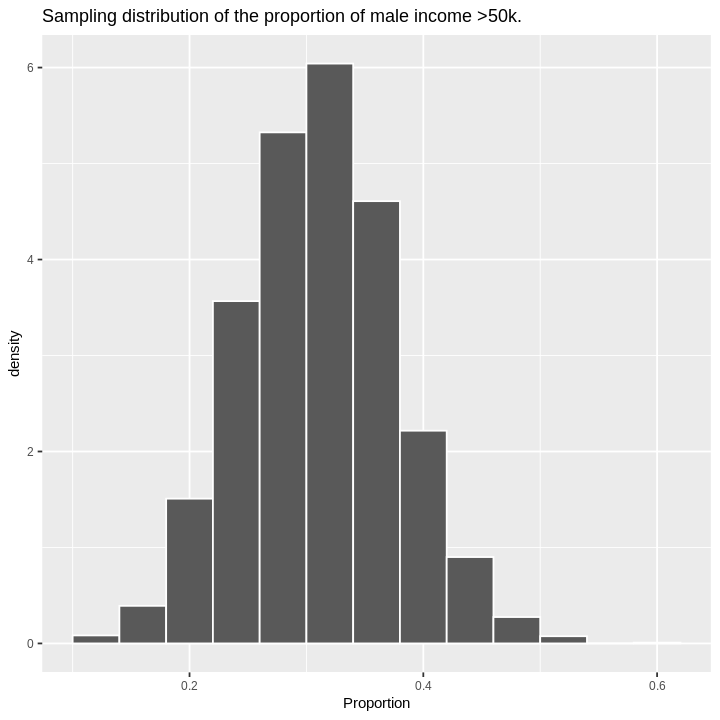

In [5]:
set.seed(100)

#Taking sample(male) of size 50

sample_male <- income_data |> 
               filter(gender == 'Male')
samples_size50 <- sample_male |>
                rep_sample_n(size = 50, reps= 3000)


#Plotting to check if the sample (male) follows an approximate normal distribution to use CLT

sampling_dist_male_size50 <-
    samples_size50 %>% 
    group_by(replicate) %>% 
    summarise(n_male = n() , 
              p = sum(income == '>50K')/(n_male), `.groups` = "drop") %>% 
    ggplot() + 
    geom_histogram(aes(x = p, y = ..density..), color="white", binwidth = 0.04) +
    theme(text = element_text(size = 9))+
    xlab("Proportion") +
    ggtitle("Sampling distribution of the proportion of male income >50k.")
sampling_dist_male_size50

**FIGURE 2: The sampling distribution of the proportion of male workers that earn more than $\$50,000$ annually**

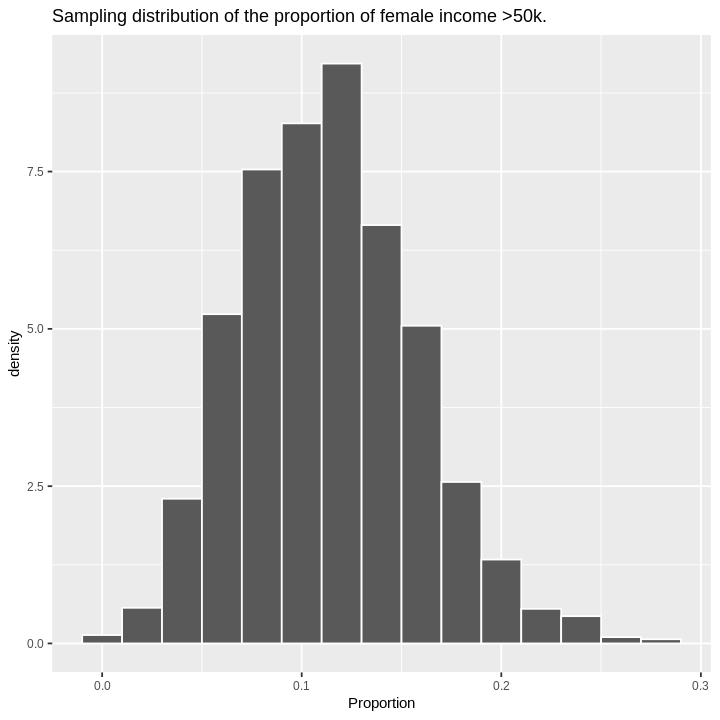

In [6]:
set.seed(100)
#Taking sample(female) of size 50
sample_female <- income_data |> 
                filter(gender == 'Female')
samples_size50 <- sample_female |>
                rep_sample_n(size = 50, reps= 3000)


#Plotting to check if the sample(female) follows an approximate normal distribution to use CLT

sampling_dist_female_size50 <-
    samples_size50 %>% 
    group_by(replicate) %>% 
    summarise(n_female = n() , 
              p = sum(income == '>50K')/(n_female), `.groups` = "drop") %>% 
    ggplot() + 
    geom_histogram(aes(x = p, y = ..density..), color="white", binwidth = 0.02) +
    theme(text = element_text(size = 9))+
    xlab("Proportion") +
    ggtitle("Sampling distribution of the proportion of female income >50k.")
sampling_dist_female_size50

**FIGURE 3: The sampling distribution of the proportion of female workers that earn more than $\$50,000$ annually**

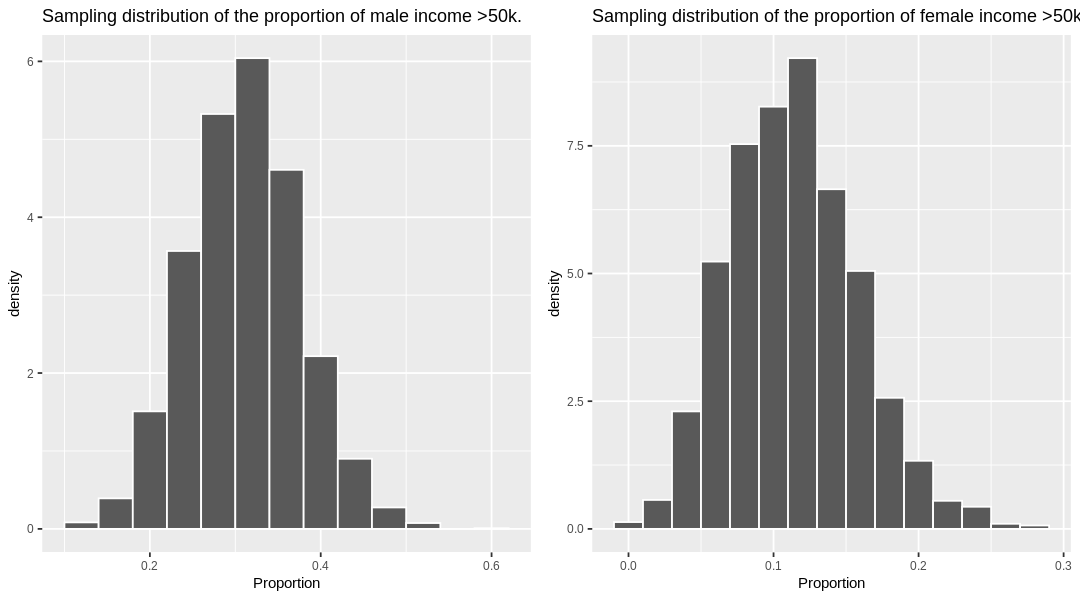

In [7]:
options(repr.plot.width = 9, repr.plot.height = 5) 
grid.arrange(sampling_dist_male_size50, sampling_dist_female_size50, ncol=2)

**FIGURE 4: Figure 2 and 3 side by side for comparison**

From Figure 2, 3 and 4, both of the sampling distributions for $p_1$ and $p_2$ are approximately normal, therefore the CLT can be applied to our hypothesis testing from now on. We begin by finding the sample proportions of $p_1$ and $p_2$. 

In [8]:
set.seed(100)
p_summary <- income_data |>
    summarise(n_female = sum(gender == 'Female'),
              n_male = sum(gender == 'Male'),
              p_female_above50k = sum(gender == 'Female' & income == '>50K')/(n_female),
              p_male_above50k = sum(gender == 'Male' & income == '>50K')/(n_male))
p_summary

n_female,n_male,p_female_above50k,p_male_above50k
<int>,<int>,<dbl>,<dbl>
8934,18577,0.1146183,0.321419


**TABLE 4 - The summary of the number and the proportion of female and male professionals that earn more than $\$50,000$ annually**

In [9]:
#'p_diff' stores the observed difference in proportion.
#'p_diff_std_error' stores the sample standard error of the difference in proportions.
set.seed(100)
p_summary_raw <-
    p_summary %>% 
    mutate(p_diff = p_male_above50k - p_female_above50k,
           p_diff_std_error = sqrt(p_male_above50k*(1-p_male_above50k)/n_male + p_female_above50k*(1-p_female_above50k)/n_female))
p_summary_raw

n_female,n_male,p_female_above50k,p_male_above50k,p_diff,p_diff_std_error
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
8934,18577,0.1146183,0.321419,0.2068006,0.004806221


**TABLE 5 - The summary of the number and the proportion of female and male professionals that earn more than $\$50,000$ annually, with the proportion difference and its standard error**

In [10]:
#Computing the confidence interval (95%)
set.seed(100)
p_summary <- 
     p_summary_raw |> 
     mutate(lower_ci = qnorm(0.025, p_diff, p_diff_std_error),
            upper_ci = qnorm(0.975, p_diff, p_diff_std_error)) |>
     select(lower_ci, upper_ci) #selecting only the columns containing the confidence interval (95%)
p_summary

lower_ci,upper_ci
<dbl>,<dbl>
0.1973806,0.2162207


**TABLE 6 - The summary of the income dataset with a 95% confidence interval using the CLT**

By generating the confidence interval of 95%, we are attempting to find  a range of values within which the population parameter, is estimated to fall into. From table 6, we are 95% certain that the difference between $p_1$ and $p_2$ fall between the range of 0.197 and 0.216. To further confirm this, we are going to use bootstrapping to verify the confidence interval generated using the CLT earlier.

### Bootstrapping

In [11]:
## Obtaining the 95% confidence interval of the difference of proportions via bootstrapping by generating 1000 samples 
set.seed(100)
diff_in_props_btsp_ci <- income_data |>
    specify(formula = income ~ gender, success='>50K') |>
    generate(type = 'bootstrap', reps = 1000, size = 50) |>
    calculate(stat = 'diff in props', order = c("Male", "Female")) |>
    get_ci()
diff_in_props_btsp_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.1972272,0.2162661


**TABLE 7 - The summary of the income dataset with a 95% confidence interval using bootstrapping**

From figures 6 and 7, both confidence intervals are relatively similar, hence, we can say that there is indeed a pay gap of jobs that pay more than $\$50,000$ annually between men and women. 

### Hypothesis Testing

We begin by defining $H_0$ and $H_A$ as:

- Null: $H_0: p_{\text{male}} - p_{female} = 0$ 
- Alternate: $H_A: p_{male} - p_{female} > 0$

In [12]:
#Obtaining Test Statistic using a z-test
set.seed(100)

n_male <- nrow(sample_male)
n_female <- nrow(sample_female)


phat_male <- p_summary_raw$p_male_above50k
phat_female <- p_summary_raw$p_female_above50k

phat <- (n_male*phat_male + n_female*phat_female)/ (n_male + n_female)

test_statistic <- (phat_male - phat_female) / sqrt(phat * (1-phat) * (1/n_male + 1/n_female))
test_statistic

[1] 36.8872

The test statistic is a number that describes how much the test results differ from $H_0$. Since the generated result is relatively large ($\approx$36.89), we can derive that the difference between phat_male and phat_female is positive and large by looking at the z-test formula. We can further check this by computing a p-value. 

In [13]:
#Obtaining a p-value

p_value <- pnorm(abs(test_statistic), lower.tail = FALSE)
p_value

[1] 3.706964e-298

In [14]:
p_summary <- p_summary |> 
            mutate(test_statistic = test_statistic,
                   p_value = p_value)

p_summary

lower_ci,upper_ci,test_statistic,p_value
<dbl>,<dbl>,<dbl>,<dbl>
0.1973806,0.2162207,36.8872,3.706964e-298


**TABLE 8 - Table containing the confidence interval, values of the test statistic and p-value**

In [15]:
p_value_check <- tidy(
        prop.test(x = c(sum(sample_female$income == ">50K"), sum(sample_male$income == ">50K")), # an array with the number of successes in each sample
                  n = c(n_female,n_male), # an array with the size of each sample
                  alternative = 'less',
                  correct = FALSE)) 

p_value_check

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1146183,0.321419,1360.665,3.706964e-298,1,-1,-0.1988951,2-sample test for equality of proportions without continuity correction,less


**TABLE 9 - Table containing the detailed information about the hypothesis test**

From looking at table 9, the obtained p-value is close to 0, therefore we reject $H_0$ at the significance level of 5%. However, this does not necessarily mean that our $H_A$ is true.

## Further analysis based on work class 

We recognise the influence of the type of employment (e.g public versus private sector jobs) on salary differences. In totality, we observed that the proportion of women earning above 50K is lower than men, indicating the presence of a wage gap. However, it is possible that the work class itself may be a confounding variable. Individuals in different work classes may have varying levels of education, and experience that affect their income. Hence, it is important to ensure that the comparison between genders is not confounded by other factors such as work class.To check this,we will further perform hypothesis testing on the proportion difference of high-paid jobs between male and female workers across various job sectors (private, public, and self-employed).

In [16]:
# Hypothesis testing for private sector jobs

n_male_priv <- sample_male %>% 
              filter(work_class == "Private") %>% nrow()
n_female_priv <- sample_female %>% 
                filter(work_class == "Private") %>% nrow()

phat_male_priv <- mean(income_data %>% 
                       filter(work_class == "Private" & gender == "Male") %>% 
                       pull(income) == ">50K")
phat_female_priv <- mean(income_data %>% 
                        filter(work_class == "Private" & gender == "Female") %>% 
                        pull(income) == ">50K")

phat_priv <- (n_male_priv * phat_male_priv + n_female_priv * phat_female_priv) / (n_male_priv + n_female_priv)

test_statistic_priv <- (phat_male_priv - phat_female_priv) / sqrt(phat_priv * (1-phat_priv) * (1/n_male_priv + 1/n_female_priv))

p_value <- pnorm(abs(test_statistic_priv), lower.tail = FALSE)

p_summary_priv <- tibble(
                    n_female_priv = n_female_priv,
                    n_male_priv = n_male_priv,
                    p_female_above50k = phat_female_priv, 
                    p_male_above50k = phat_male_priv,
                    test_statistic = test_statistic_priv,
                    p_value = p_value)
p_summary_priv

n_female_priv,n_male_priv,p_female_above50k,p_male_above50k,test_statistic,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
6926,13209,0.09558187,0.2936634,31.94784,2.894255e-224


**TABLE 10 - A hypothesis testing summary table for jobs in the private sector** 

We see that for a 5% significance level the p-value is less than < 0.05 so we have enough evidence to reject the null. 

In [19]:
# Hypothesis testing for public sector jobs

n_male_gov <- sample_male %>% 
              filter(work_class == "Gov") %>% nrow()
n_female_gov <- sample_female %>% 
                filter(work_class == "Gov") %>% nrow()

phat_male_gov <- mean(income_data %>% filter(work_class == "Gov" & gender == "Male") %>% pull(income) == ">50K")
phat_female_gov <- mean(income_data %>% filter(work_class == "Gov" & gender == "Female") %>% pull(income) == ">50K")

phat_gov <- (n_male_gov * phat_male_gov + n_female_gov * phat_female_gov) / (n_male_gov + n_female_gov)

test_statistic_gov <- (phat_male_gov - phat_female_gov) / sqrt(phat_gov * (1-phat_gov) * (1/n_male_gov + 1/n_female_gov))

p_value <- pnorm(abs(test_statistic_gov), lower.tail = FALSE)

p_summary_gov <- tibble(
                    n_female_gov = n_female_gov,
                    n_male_gov = n_male_gov,
                    p_female_above50k = phat_female_gov, 
                    p_male_above50k = phat_male_gov,
                    test_statistic = test_statistic_gov,
                    p_value = p_value)
p_summary_gov

n_female_gov,n_male_gov,p_female_above50k,p_male_above50k,test_statistic,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1536,2516,0.1673177,0.3895072,14.89996,1.648953e-50


**TABLE 11 - A hypothesis testing summary table for jobs in the government sector** 

We see that for a 5% significance level the p-value is less than < 0.05 so we have enough evidence to reject the null.

In [18]:
# Hypothesis testing for those who identify as self-employed

p_summary_self <- income_data |>
    summarise(n_female_self = sum(gender == 'Female' & work_class == 'Self-employed'),
              n_male_self = sum(gender == 'Male' & work_class == 'Self-employed'),
              p_female_above50k = sum(gender == 'Female' & income == '>50K' & work_class == 'Self-employed')/(n_female_self),
              p_male_above50k = sum(gender == 'Male' & income == '>50K' & work_class == 'Self-employed')/(n_male_self))

n_male_self <- p_summary_self$n_male_self
n_female_self <- p_summary_self$n_female_self


phat_male_self <- p_summary_self$p_male_above50k
phat_female_self <- p_summary_self$p_female_above50k

phat_self <- (n_male_self*phat_male_self + n_female_self*phat_female_self)/ (n_male_self + n_female_self)

test_statistic <- (phat_male_self - phat_female_self) / sqrt(phat_self * (1-phat_self) * (1/n_male_self + 1/n_female_self))

p_value_self <- pnorm(abs(test_statistic), lower.tail = FALSE)

p_summary_self <- p_summary_self |>
     mutate(test_statistic = test_statistic,
            p_value = p_value_self)
p_summary_self

n_female_self,n_male_self,p_female_above50k,p_male_above50k,test_statistic,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
465,2839,0.2258065,0.3916872,6.874145,3.118133e-12


**TABLE 12 - A hypothesis testing summary table for those who identify as self-employed** 

We see that for a 5% significance level the p-value is less than < 0.05 so we have enough evidence to reject the null.

Looking at the tables 10, 11 and 13, the p-value computed across different employment sectors are relatively close to 0. As a result, we reject $H_0$, regardless of employment sector, at the significance level of 5%. Therefore, we find that the p-value for each work class is less than 0.05, meaning that the wage gap exists within each work class as well.

## DISCUSSION

In conclusion, we can reject the null hypothesis based on the computed p-value. From looking at table 9, the obtained p-value is close to 0, therefore we reject $H_0$ at the significance level of 5%. Moreover, from the tables 10, 11 and 13, the p-value computed across different employment sectors are relatively close to 0. As a result, we reject $H_0$, regardless of employment sector, at the significance level of 5%. However, it is important to note that this does not necessarily mean that our $H_A$ is true.

Understanding the reason behind the gender pay gap in the United States is important because it might be able to confirm the issue of workplace inequality and also gender inequality as a whole. Addressing this issue may involve implementing policies aimed at promoting gender equality in the workplace, as well as raising awareness and challenging cultural norms and biases that may be contributing to the problem.

Moreover, we recognise the weaknesses of the chosen dataset: the salary is divided into two categories, those who earn $\$50,000$ or less and those who earn more than $\$50,000$ instead of specific numbers. Categorising this can lead to data analysis inaccuracy as the salary could be as low as $\$50,000$ or as high as $\$1$ million. Such a large range will have further impacts on the investigation of gender pay gap and the extent of the difference. 

## REFERENCES

Kochhar, R. (2023, March 1). The enduring grip of the gender pay gap. Pew Research Center's Social & Demographic Trends Project. Retrieved March 18, 2023, from https://www.pewresearch.org/social-trends/2023/03/01/the-enduring-grip-of-the-gender-pay-gap/ 

Kohavi, R., &amp; Becker, B. (1994). Census Income Data Set. UCI Machine Learning Repository: Census Income Data Set. Retrieved March 18, 2023, from https://archive.ics.uci.edu/ml/datasets/Census+Income 

United Nations. (2017). UN/DESA Policy Brief #53: Reflection on development policy in the 1970s and 1980s | Department of Economic and Social Affairs. United Nations. Retrieved March 18, 2023, from https://www.un.org/development/desa/dpad/publication/policy-brief-53-reflection-on-development-policy-in-the-1970s-and-1980s/ 